In [2]:
from gensim.models.keyedvectors import KeyedVectors

word2VecModel = KeyedVectors.load_word2vec_format('D:/gn/GoogleNews-vectors-negative300.bin', binary=True)

angry = word2VecModel['angry']
disgust = word2VecModel['disgust']
fear = word2VecModel['fear']
happy = word2VecModel['happy']
neutral = word2VecModel['neutral']
sad = word2VecModel['sad']
surprise = word2VecModel['surprise']

weight = [angry, disgust, fear, happy, neutral, sad, surprise]


In [3]:
import tensorflow
print(tensorflow.test.is_built_with_cuda())
print(tensorflow.test.is_built_with_gpu_support())

True
True


In [4]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

print("a")

a


ax = sns.scatterplot(data=weight)

In [5]:
train_dir = "images/train" #passing the path with training images
test_dir = "images/validation"   #passing the path with testing images

In [19]:
img_size = 48 #original size of the image
_batch_size = 64

In [20]:
"""
Data Augmentation
--------------------------
rotation_range = rotates the image with the amount of degrees we provide
width_shift_range = shifts the image randomly to the right or left along the width of the image
height_shift range = shifts image randomly to up or below along the height of the image
horizontal_flip = flips the image horizontally
rescale = to scale down the pizel values in our image between 0 and 1
zoom_range = applies random zoom to our object
validation_split = reserves some images to be used for validation purpose
"""

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                validation_split = 0.1,)
validation_datagen = ImageDataGenerator(validation_split = 0.2)

In [21]:
"""
Applying data augmentation to the images as we read 
them from their respective directories
"""
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    class_mode = "categorical",
                                                    color_mode = "grayscale",
                                                    subset = "training",
                                                    batch_size=_batch_size,
                                                    shuffle=True
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              class_mode = "categorical",
                                                              color_mode = "grayscale",
                                                              subset = "validation",
                                                              batch_size=_batch_size
                                                             )

Found 1260 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [9]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

class CustomModel(keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            w = -100
            for n in range(len(weight) - 1) : 
                a = cosine_similarity(a, y_pred)
                if w < a :
                    w = a
                    y_pred = n
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

cosine_loss = tf.keras.losses.CosineSimilarity(axis=1)

class NumLoss(tf.keras.losses.Loss) :
    def call(self, y_true, y_pred):
        difference = 0.
        for n in range(len(y_true.numpy().tolist())-1) : 
            y_true_n = y_true.numpy().tolist()[n]
            y_pred_n = y_pred.numpy().tolist()[n]
            difference += abs(weight[int(y_true_n[0])] - y_pred_n)
        m = tf.reduce_mean(difference / _batch_size) 
        print(m)
        return m

class WeightLayer(keras.layers.Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(WeightLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(WeightLayer, self).build(input_shape)

    def call(self, x):
        return keras.backend.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


m_input = keras.Input(shape=(img_size, img_size, 1))
x = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(m_input)

x = keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(512, (3,3), padding='same', activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)
m_output = keras.layers.Dense(300, activation='relu')

model = CustomModel(m_input, m_output)

In [10]:
model= tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(300, activation = 'sigmoid'))

model= tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1), kernel_regularizer=regularizers.l2(0.01)))
model.add(Flatten()) 
model.add(Dense(300, activation = 'sigmoid'))

In [11]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [22]:


cosine_loss = tf.keras.losses.CosineSimilarity()

class NumLoss2(tf.keras.losses.Loss) :
    def call(self, y_true, y_pred):
        y_true_n = y_true.numpy().tolist()[0]
        y_pred_n = y_pred.numpy().tolist()[0]
        difference_n = abs(cosine_loss(weight[int(max(y_true_n))], y_pred_n).numpy())
        for n in range(1, len(y_true.numpy().tolist())-2) : 
            y_true_n = y_true.numpy().tolist()[n]
            y_pred_n = y_pred.numpy().tolist()[n]
            difference = abs(cosine_loss(weight[int(max(y_true_n))], y_pred_n).numpy())
            difference_n = difference + difference_n
        m = difference_n / _batch_size
        return m

In [23]:

cosine_loss = tf.keras.losses.CosineSimilarity()

class NumLoss(tf.keras.losses.Loss) :
    def call(self, y_true, y_pred):
        y_true_n = y_true.numpy().tolist()[0]
        t = weight[y_true_n.index(int(max(y_true_n)))]
        y_pred_n = y_pred.numpy().tolist()[0]
        loss = tf.keras.losses.cosine_similarity(t, y_pred_n)
        for i in range(1, len(y_true.numpy().tolist())-2) : 
            y_true_n = y_true.numpy().tolist()[i]
            t = weight[y_true_n.index(int(max(y_true_n)))]
            y_pred_n = y_pred.numpy().tolist()[i]
            loss += tf.keras.losses.cosine_similarity(t, y_pred_n)
        return tf.reduce_sum(loss)

In [14]:
def category_accuracy():
    def accuracy(y_true, y_pred):
        score = 0
        for n in range(len(y_true.numpy().tolist())-1) : 
            y_pred_n = [y_pred.numpy().tolist()[n][i] - 0.5 for i in range(len(y_pred.numpy().tolist()[n]))]
            y_true_n = y_true.numpy().tolist()[n]
            i = 0
            w = 0.00
            for m in range(len(weight)) : 
                a = abs(cosine_similarity(weight[m], y_pred_n))
                if w < a : 
                    w = a
                    i = m
            if int(i) == int(y_true_n.index(int(max(y_true_n)))) :
                score += 1
            print("pred", i, "gt", y_true_n.index(int(max(y_true_n))))
        return score / _batch_size
    return accuracy

In [30]:
model.compile(
    run_eagerly = True,
    optimizer = Adam(learning_rate=0.00001), 
    loss=NumLoss(),
    metrics=[category_accuracy()]
  )

In [16]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [31]:
epochs = 10
batch_size=_batch_size

In [32]:
history = model.fit(x = train_generator, epochs = epochs, validation_data = validation_generator)

Epoch 1/10
pred 2 gt 2
pred 1 gt 5
pred 2 gt 4
pred 1 gt 4
pred 1 gt 1
pred 1 gt 4
pred 4 gt 5
pred 1 gt 3
pred 1 gt 0
pred 4 gt 3
pred 2 gt 0
pred 1 gt 6
pred 1 gt 6
pred 4 gt 2
pred 2 gt 0
pred 4 gt 1
pred 3 gt 2
pred 1 gt 5
pred 4 gt 3
pred 1 gt 4
pred 4 gt 2
pred 1 gt 5
pred 4 gt 6
pred 1 gt 5
pred 2 gt 2
pred 4 gt 2
pred 2 gt 2
pred 3 gt 1
pred 1 gt 1
pred 1 gt 3
pred 1 gt 2
pred 6 gt 1
pred 0 gt 5
pred 5 gt 4
pred 2 gt 6
pred 0 gt 2
pred 0 gt 4
pred 1 gt 1
pred 0 gt 0
pred 6 gt 4
pred 2 gt 2
pred 4 gt 6
pred 4 gt 2
pred 1 gt 5
pred 4 gt 4
pred 4 gt 0
pred 1 gt 0
pred 6 gt 4
pred 2 gt 3
pred 4 gt 1
pred 1 gt 4
pred 4 gt 6
pred 1 gt 3
pred 3 gt 5
pred 3 gt 1
pred 5 gt 4
pred 3 gt 2
pred 1 gt 6
pred 0 gt 2
pred 5 gt 6
pred 0 gt 4
pred 0 gt 6
pred 3 gt 0
 1/20 [>.............................] - ETA: 1:31 - loss: -0.8019 - accuracy: 0.1406WARNING:tensorflow:Gradients do not exist for variables ['conv2d/kernel:0', 'conv2d/bias:0', 'conv2d_1/kernel:0', 'conv2d_1/bias:0', 'batch_normaliz

KeyboardInterrupt: 

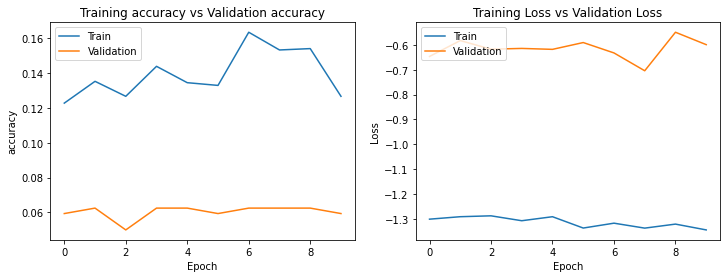

In [28]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training accuracy vs Validation accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [29]:
model.save('model_optimal.h5')

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train recall = {:.2f} , validation recall = {:.2f} , train_loss = {:.2f} , validation_loss = {:.2f}".format(train_acc*100, test_acc*100, train_loss, test_loss))

In [ ]:


# t-SNE 시각화 함수 정의
def plot_vecs_n_labels(v, labels, fname):
    fig = plt.figure(figsize = (10,10))
    plt.axis('off')
    sns.set_style('darkgrid')
    sns.scatterplot(v[:,0], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.legend(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
    plt.savefig(fname)




val_dl = validation_generator

for x, y in val_dl:
    #x = x.to(device)
    pred = model.predict(x)
    w = -100 
    for m in range(len(weight)) :
        a = cosine_similarity(weight[m], pred[1])
        if w < a : 
            w = a
            i = m
    pred = [[i]]
        #pred = linear_classifier(pred)
        
    # 모델의 출력값을 tsne.fit_transform에 입력하기
    pred_tsne = tsne.fit_transform(x.reshape(-1, 1), pred)
    
    # t-SNE 시각화 함수 실행
    plot_vecs_n_labels(pred_tsne, y, 'tsen.png')
    break

In [ ]:
model.save_weights('model_weights.h5')